In [21]:
import sys
sys.path.insert(0, '/Users/hosseinb/projects/llm-orchestrated-computational-intelligence')

from pydantic import BaseModel
from utils import llm_service
import importlib

# Reload modules (run this cell again after making changes to source files)
importlib.reload(llm_service)

# Reload ACO specifically, then reload methods to pick up changes
from methods import aco
importlib.reload(aco)

import methods
importlib.reload(methods)

<module 'methods' from '/Users/hosseinb/projects/llm-orchestrated-computational-intelligence/src/methods/__init__.py'>

In [2]:

resp = llm_service.get_chat_completion(llm_service.Model.GLM_4_7.value, 
[
    {"role": "system", "content": "Hello, world! what do you think?"}, 
    {"role": "user", "content": "what is 2+2?"}
], 
max_tokens=200)
resp

'2 + 2 is 4.'

In [8]:
class Answer(BaseModel):
    answer: int
    reason: str

resp = llm_service.get_chat_completion_structured(llm_service.Model.GLM_4_7.value, 
[
    {"role": "system", "content": "Hello, world! what do you think?"}, 
    {"role": "user", "content": "what is 2+2?"}
], 
Answer,
max_tokens=200)
resp

Answer(answer=4, reason='Basic arithmetic addition.')

# Test select_method

In [2]:
problem_info = """
Problem: Traveling Salesman Problem
Cities: 10
Distance Matrix:
[[  0,  29,  82,  46,  68,  52,  72,  42,  51,  55],
 [ 29,   0,  55,  46,  42,  43,  43,  23,  23,  31],
 [ 82,  55,   0,  68,  46,  55,  23,  43,  41,  29],
 [ 46,  46,  68,   0,  82,  15,  72,  31,  62,  42],
 [ 68,  42,  46,  82,   0,  74,  23,  52,  21,  46],
 [ 52,  43,  55,  15,  74,   0,  61,  23,  55,  31],
 [ 72,  43,  23,  72,  23,  61,   0,  42,  23,  31],
 [ 42,  23,  43,  31,  52,  23,  42,   0,  33,  15],
 [ 51,  23,  41,  62,  21,  55,  23,  33,   0,  29],
 [ 55,  31,  29,  42,  46,  31,  31,  15,  29,   0]]
Objective: Minimize total tour distance
Time Limit: 60 seconds
Priority: Solution quality over speed
"""

In [3]:
from orchestrator.method_selector import select_method
result = select_method(problem_info, model=llm_service.Model.GPT_OSS.value)

In [4]:
# Check the LLM selection result
print("Selected Method:", result["selected_method"])
print("Parameters:", result["parameters"])
print("Reasoning:", result["reasoning"])

Selected Method: aco
Parameters: {'n_ants': 50, 'alpha': 1.0, 'beta': 3.0, 'evaporation_rate': 0.3, 'iterations': 1000}
Reasoning: The problem is a classic TSP with 10 cities. ACO is the primary method for graph‑based routing problems and can exploit the distance matrix to construct high‑quality tours. Since the user prioritizes solution quality over speed and the time limit (60 s) is generous for a 10‑city instance, we can allocate more computational effort by increasing the number of ants and iterations. A higher beta (heuristic importance) and a lower evaporation rate help the colony focus on short edges while still exploring alternative routes, leading to better convergence on the optimal or near‑optimal tour.


In [5]:
import numpy as np
from methods import get_method
from problems.tsp import TSPProblem

# Define the distance matrix from problem_info
distance_matrix = [
    [  0,  29,  82,  46,  68,  52,  72,  42,  51,  55],
    [ 29,   0,  55,  46,  42,  43,  43,  23,  23,  31],
    [ 82,  55,   0,  68,  46,  55,  23,  43,  41,  29],
    [ 46,  46,  68,   0,  82,  15,  72,  31,  62,  42],
    [ 68,  42,  46,  82,   0,  74,  23,  52,  21,  46],
    [ 52,  43,  55,  15,  74,   0,  61,  23,  55,  31],
    [ 72,  43,  23,  72,  23,  61,   0,  42,  23,  31],
    [ 42,  23,  43,  31,  52,  23,  42,   0,  33,  15],
    [ 51,  23,  41,  62,  21,  55,  23,  33,   0,  29],
    [ 55,  31,  29,  42,  46,  31,  31,  15,  29,   0]
]

# Create TSP problem using the existing class
problem = TSPProblem({
    "n_cities": 10,
    "distance_matrix": np.array(distance_matrix)
})

In [22]:
# Get the method instance using the LLM's selection
method = get_method(result["selected_method"])

# Run the method with LLM-suggested parameters
result["parameters"].update({"n_ants": 2})
aco_result = method.run(problem, result["parameters"])

# Display results
print(f"Best Tour: {aco_result['best_solution']}")
print(f"Best Tour Length: {aco_result['best_fitness']:.2f}")
print(f"Computation Time: {aco_result['computation_time']:.2f}s")
print(f"Iterations: {aco_result['iterations_completed']}")

Best Tour: [0, 1, 8, 4, 6, 2, 9, 7, 5, 3]
Best Tour Length: 247.00
Computation Time: 0.19s
Iterations: 1000


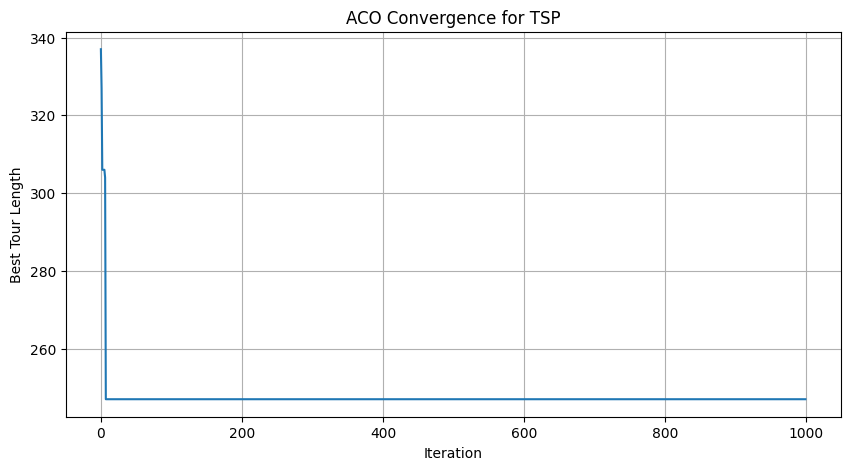

In [23]:
# Plot convergence curve
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(aco_result['convergence_history'])
plt.xlabel('Iteration')
plt.ylabel('Best Tour Length')
plt.title('ACO Convergence for TSP')
plt.grid(True)
plt.show()